# Synthesizing Birdsong

#### ECE 4760, Fall 2021, Adams/Land

[Spring, 2021 version](./Birdsong_serial.html)

## Webpage table of contents

> - [Background and Introduction](#Background-and-Introduction)
> - [Required reading](#Required-reading)
> - [Program Organization and Debugging](#Program-Organization-and-Debugging)
> - [Weekly Checkpoints and Lab Report Specifications](#Weekly-Checkpoints-and-Lab-Report)
> > - [Week one](#Week-one-required-checkpoint)
> > - [Week two](#Week-two-required-checkpoint)
> > - [Week three](#Week-three-assignment)
> > - [ECE 5730 students](#ECE-5730-students)
> > - [Lab Report](#Lab-report)
> - [Demonstrations of Working System (for reference)](#Demonstrations-of-working-system)


## Background and Introduction

We will be using direct digital synthesis to generate the call of the northern cardinal. Specifically, [this](https://macaulaylibrary.org/asset/130905?__hstc=75100365.b8a8ce99cbef50e187883000d2a8e38b.1601856173825.1602249083165.1603396221676.6&__hssc=75100365.1.1603396221676&__hsfp=2840701297#_ga=2.15404978.520534262.1603396221-116006615.1601856172) adult male northern cardinal recorded by Gerrit Vyn in 2006. This bird was recorded in Texas, but cardinals are also common in Ithaca and throughout the eastern United States. If you pay attention when you're walking through campus, you may hear one singing. The males are a very striking red. You can read more about the cardinal [here](https://www.allaboutbirds.org/guide/Northern_Cardinal).

<figure>
    <img align="center" width="500" height="500" src="cardinal.jpg" alt='missing' />
    <center><figcaption>A northern cardinal</figcaption></center>
</figure>

Cardinals have a variety of songs and calls. We will be synthesizing on of its most common songs, which you can hear in the first ten seconds of the recording below:

<iframe align="center" width="800" height="356" src="https://macaulaylibrary.org/asset/130905/embed/640" frameborder="0" allowfullscreen style="width:800px;"></iframe>

Here is a screenshot of the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) for the song that we'll be synthesizing. Cardinals and many other songbirds produce almost pure frequency-modulated tones. As can be seen in the spectrogram below, the cardinal sweeps through frequencies from ~2kHz to ~7kHz. We'll assume that the dominant tones  (the darkest lines on the spectrogram) are significantly louder than all other frequencies (the lighter lines). We'll only synthesize these loudest frequencies. The generated song sounds quite realistic under this assumption. Your synthesizer will be controlled via a keypad.

<img align="center" width="1000" height="1000" src="spectrogram.png">

***

## Required reading

Experience shows that students prefer these webpages short. For that reason, please see these external pages for additional information which will be *critical* to completing this particular lab.

> - [**Direct digital synthesis (DDS)**](https://vanhunteradams.com/DDS/DDS.html): This is the algorithm that we will use for sound production. *This is a powerful algorithm*, a good one to understand deeply.
> - [**Birdsong synthesis via DDS**](./Birdsong_synthesis.html): This webpage deconstructs the Northern cardinal's song, and synthesizes it via DDS.
> - [**Keypad**](https://people.ece.cornell.edu/land/courses/ece4760/PIC32/index_keypad.html): Your birdsong synthesizer will be cotrolled via a keypad. Please see this page for examples of and information about the the keypad that we will be using.
> - [**Sound synthesis page**](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/index_sound_synth.html): Generally speaking you want to make pleasant sounding synthesis. You may want to look at the sound synthesis page. I suggest starting with a linear attack of about 1000 samples, a decay of about 1000 samples, and a sustain as long as necessary for a 130ms chirp/swoop.
> - [**DAC datasheet**](http://people.ece.cornell.edu/land/courses/ece4760/labs/f2019/lab2_mcp4822.pdf): The SPI DAC you will use is the MCP4822. The DAC analog output is marked DACA or DACB on the SECABB. The SPI connections are supplied on the Big Board (SECABB), as long as you connect the DAC_CS jumper. Section 5.1 and 5.2 of the MCP4822 datasheet discussed the way the the DAC uses SPI. The edge connector pin marked DACA or DACB will go (optionally through a low pass filter) to an audio socket, to be connected to the green audio plug of the speakers. If you are going to design a lowpass filter for the DAC, then you need to know that the input impedance of the speakers is around 10 Kohm.
<figure>
    <img align="center" width="200" height="200" src="audio_socket.png" alt='missing' />
    <center><figcaption>Audio socket. The pin nearest the socket is ground. Left/right channels are wired together.</figcaption></center>
</figure>
<figure>
    <img align="center" width="200" height="200" src="audio_plug.png" alt='missing' />
    <center><figcaption>Speaker audio input plug.</figcaption></center>
</figure>

> - [**Hardware/Software setup for PIC32**](https://vanhunteradams.com/4760/PIC32_HW_SW.html): This page describes the software/hardware required for configuring this lab.

***

## Program Organization and Debugging

### Program Organization

I suggest that you organize the program as follows. If a different organization makes more sense to you, that's ok. This is just a suggestion.

- **Protothreads** maintains the ISR-driven, millisecond-scale timing as part of the supplied system. Use this for all low-precision timing (can have several milliseconds jitter).
- **Synthesis ISR** uses a timer interrupt to ensure an exact 44KHz synthesis sample rate.
> - DDS of sine waves
> - DAC output
> - Sample count for precise timing of sounds
- **Main** sets up peripherals and protothreads then just schedules tasks, round-robin
- **Keypad Thread**
> - Scans and debounces the keypad and any other buttons you may use
> - Your state machine must debounce all 12 keys.
> - Parses the command (if any) and updates state variables (play mode, sound list, etc.)
> - Waits for 10-30 mSec using `PT_YIELD_TIME_msec(time)`, then repeats.
- **Play Thread**
> - Waits to be semaphore-signalled by a different thread
> - Plays the sound associated with each button press recorded in the global array by setting up the DDS parameters associated with each sound
> - Maintains playback timing using the sample count from the timer ISR

You may find some [previous year's lectures](https://www.youtube.com/playlist?list=PLDqMkB5cbBA6FEJuj94gl-9vw8xcHu9Gp) useful. You may also find [Bruce's lectures](https://www.youtube.com/playlist?list=PLKcjQ_UFkrd43P4lgzCot1hgiUu8onfaj) useful.

Timing of all functions in this lab, **and every exercise in this course** will be handled by interrupt-driven counters, (including the builtin functions in ProtoThreads) and not by software wait-loops. This will be enforced because wait-loops are hard to debug and tend to limit multitasking. You may not use any form of a delay(mSec) function.

### Debugging

If your program just sits there and does nothing:

- Did you turn on interrupts? The thread timer depends on an interrupt.
- Did you write each thread to include at least one `YIELD` (or `YIELD_UNTIL`, or `YIELD_TIME_msec`) in the `while(1)` loop?
- Did you schedule the threads?
- Did you ask to initialize the TFT display in the code, while not having a TFT on the board?
- Does the board have power?

If your program reboots about 5 times/second:

- Did you exit from any *scheduled* threads? This blows out the stack.
- Did you turn on *any* interrupt source and fail to write an ISR for that source?
- Did you divide by zero? A divide by zero is an untrapped exception.
- Did you write to any non-existant memory location, perhaps by using a negative (or very large) array index?

If your thread state variables seem to change on their own:

- Did you define any *automatic local variable*? Local variables in a thread should be *static*.
- Are your global or static arrays big enough to clobber the stack in high memory? You should be able to use over 30kbytes.

**The oscilloscope is essential for debugging this lab (and every lab). The oscilloscope is the only way of deciding if -- It doesn't work! -- results from hardware or software.**

***

## Weekly Checkpoints and Lab Report

Note that these checkpoints are **cumulative.** In week 2, for example, you must have also completed all of the requirements from week 1.

#### Week one required checkpoint

By the end of lab session in week one you must have either built and tested your own board *or* tested a prebuilt board.

- *Before you test, be sure to attach the chip-select jumpers for the Port Expander, TFT, and DAC.*
- The current version of Protothreads is 1_3_2. All example programs using this threader may be found on the [Development board page](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/target_board.html#sw_for_SECABB). Download the ZIP file on this page to get all the libraries and substitute in the following source code: <br> Program example 3, **DDS_Accum_Expander_BRL4.c** on the [Development board page](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/target_board.html#sw_for_SECABB) is the basis for this lab.
- Run this example.
- For most of the semester you will be using the TFT LCD for output and debugging. You will need to use some of the graphics library calls described in the test code in this lab.<br>Test code: [TFT_test_BRL4.c](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Target_board/TFT_test_BRL4.c) -- displays color patches, system time, moves a ball, generates a slow ramp on the DAC, and blinks the LED. Run this example.
- You may want to refer to the [ProtoThreads page](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/index_Protothreads.html) for the general threading setup. 

#### Week two required checkpoint

- *Basic keypad interface* working. You should be able to press 1 on the keypad and hear exactly one swoop sound (not necessarily amplitude modulated) and you should be able to press 2 on the keypad and hear exactly one chirp sound. 
- Both sounds should appear on the scope.
- Do this by integrating the **DDS_Accum_Expander_BRL4.c** on the [Development board page](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/target_board.html#sw_for_SECABB) and example on the [keypad page](https://people.ece.cornell.edu/land/courses/ece4760/PIC32/index_keypad.html)
- *Finishing a checkpoint does NOT mean you can leave lab early!*

#### Week three assignment

Timing of all functions in this lab, **and in every exercise in this course** will be handled by interrupt-driven counters, not by software wait-loops. ProtoThreads maintains an ISR driven timer for you. This will be enforced because wait-loops are hard to debug and tend to limit multitasking

*Write a Protothreads C program which will:*

- The program starts in *play mode.* The program will play the swoop sound when the 1 key is pressed and the chirp sound when the 2 key key is pressed. Each sound will play for 130ms, exactly once, independent of the duration of the button push.
- The program will produce 130ms of silence when the 3 key is pressed. This is mostly useful in *record mode* (see below).
- In *play mode*, the program will play the recorded sequence of sounds. The sounds will play with an amplitude envelope that you choose. There may not be any clicks, pops, or other audio artifacts.
- The program should have two modes:
> - Upon power-up or reset the system should go into *play mode* and play a sound for each button press (swoop for key 1, chirp for key 2, and 130 ms of silence for key 3).
> - Pressing and holding a separate button (not the keypad) or toggling a switch puts the system into *record mode* so that each button press is recorded for later playback. Recording continues until the *record mode* toggle is released. The duration of each button press does not affect the recording.
- The program should include two frequency sweeps (the swoop and chirp) that you can hard-code.
- There should be no clicks, pops, or other audio facts of synthesis.

When you demonstrate the program to a staff member, you will be asked to play back a sequence of sounds which simulates the birdsong above, and to play back a random sequence of swoops/chirps/silences. At no time during the demo can you reset or reprogram the MCU.

#### *ECE 5730 students*

In addition to the above, ECE 5730 students should synthesize another Northern Cardinal song, shown below. You may deconstruct this song into 4 sound primitives, as illustrated below. Fit these frequency sweeps to functions using similar analysis to that shown at the top of this document.

Each of these 4 sound primitives should be mapped to 4 additional keys on the keypad.

You may fit to any function that you like. 2 linear functions and a parabolic function sound nice.

<img align="center" width="1000" height="1000" src="Down.png">

<img align="center" width="1000" height="1000" src="Down_annotated.png">

You can also synthesize songs for other, more challenging birds like the [Baltimore oriole](https://macaulaylibrary.org/asset/93753?__hstc=75100365.4af4b5ec7660d0673dacf4700155172a.1603723056763.1603723056763.1603723056763.1&__hssc=75100365.1.1603723056764&__hsfp=3874643835#_ga=2.88178002.855674868.1603723056-1513990777.1603723055). (If you're lucky, you can spot these in Ithaca too. They're gorgeous and have a very distinctive song).

#### Lab report

Your written lab report should include the sections mentioned in the [policy page](http://people.ece.cornell.edu/land/courses/ece4760/EE4760_policy.html), and:

- A scope display of a swoop/chirp birdcall showing rise, sustain, fall
- A spectrogram of the sound produced by your MCU
- A heavily commented listing of your code

***

## Demonstrations of working system

<iframe width="560" height="315" src="https://www.youtube.com/embed/hzVt9v33ktI" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

By plugging the Pic into the microphone input of the PC, we can record the sound that it generates and create a spectrogram of the Pic-generated birdsong:

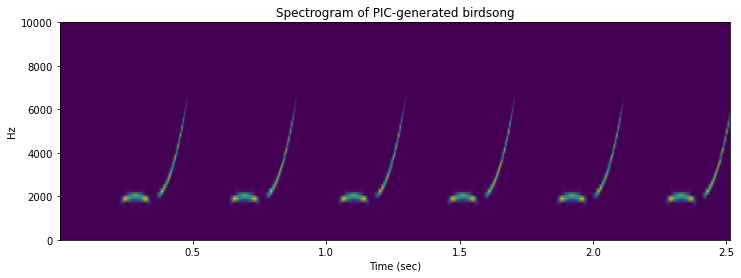

In [19]:
samplerate, data = wavfile.read('./Bird.wav')
frequencies, times, spectrogram = signal.spectrogram((data[80000:191000,0]+data[80000:191000,1])/2., samplerate)
plt.pcolormesh(times, frequencies, spectrogram,  shading='gouraud')
plt.ylabel('Hz'); plt.xlabel('Time (sec)')
plt.title('Spectrogram of PIC-generated birdsong')
plt.ylim([0,10000])
plt.show()

#### Includes (please ignore)

In [2]:
import numpy
import matplotlib.pyplot as plt
from IPython.display import Audio
from IPython.display import Image
from scipy import signal
from scipy.fft import fftshift
from scipy.io import wavfile
plt.rcParams['figure.figsize'] = [12, 4]
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")